In [1]:
import sys
from os import path
sys.path.append(path.abspath('') + "/../..")

In [2]:
import sifi_cm.root_aux as raux
import matplotlib.pyplot as plt
import numpy as np
import uproot
# from collections import namedtuple
import os
import pandas as pd
from sifi_cm.hypmed import HypmedImporter, Reco_image, figure_layers,\
                           get_vec_from_layers, get_map, get_hypmed_data
from sifi_cm.data_fit import fit_1d, Gaussian_1D, fit_2d

In [3]:
# mapping file and coordinates of crystals 
mapping, coord = get_map("../../sifi_cm/data/hypmed/crystal_v2.root")

## Preprocessing - efficiency map construction

In [4]:
hypmed_data = "/home/vitalii/SiFi/Programs/Measurements/hypmed_data/"

In [5]:
# background data
data_bg = get_hypmed_data(
    hypmed_data + "ordered_TestCodedMaskNoSource3_8_20min.root",
    mapping, verbose=True)


Total measurement time:  20.02 [min]


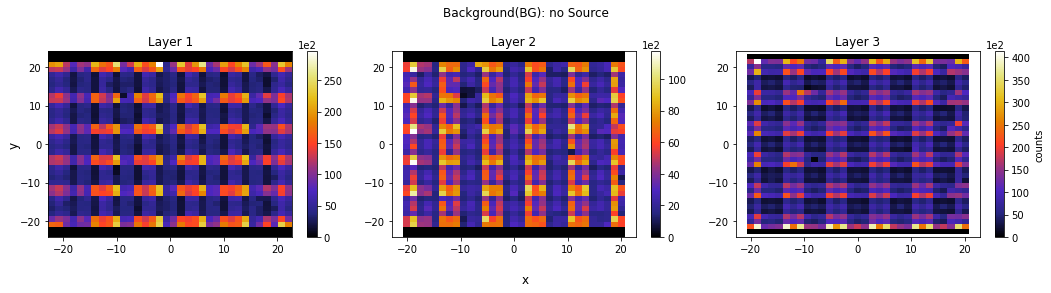

In [6]:
fig = figure_layers(data_bg, coord, label="Background(BG): no Source")
fig.savefig("./figures/bg_layers.png", facecolor="white", dpi=600)

In [7]:
data_nomask = get_hypmed_data(hypmed_data + "ordered_TestCodedMaskWithoutMask3_8_20min.root",
                              mapping, verbose=True)

Total measurement time:  20.02 [min]


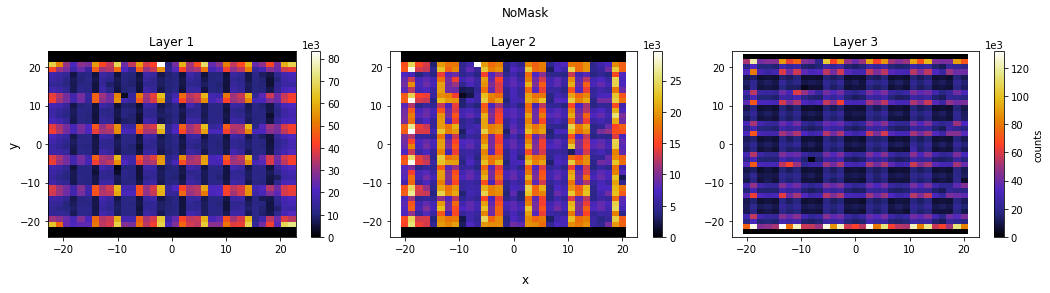

In [8]:
fig = figure_layers(data_nomask, coord, label="NoMask")
fig.savefig("./figures/nomask_layers.png", facecolor="white", dpi=600)

In [9]:
df_pproc = pd.merge(data_nomask, data_bg[["NeedleNumber", "PhotonsRoi"]], on="NeedleNumber",
         suffixes=("_nomask", "_bg"))

In [10]:
df_pproc["PhotonsRoi_nomask_bgfree"] = df_pproc["PhotonsRoi_nomask"] - df_pproc["PhotonsRoi_bg"]

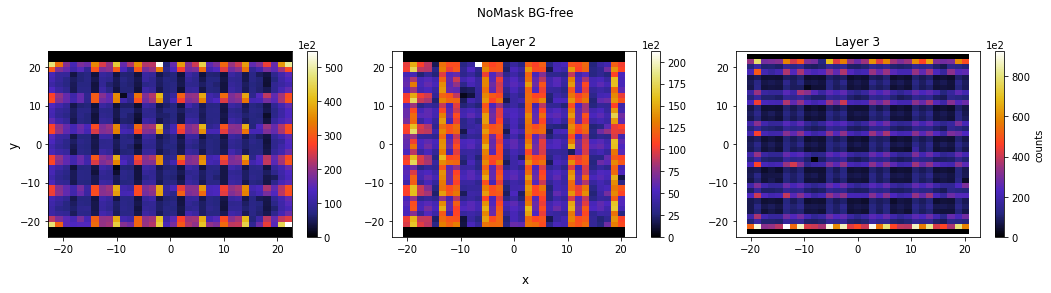

In [11]:
fig = figure_layers(df_pproc, coord, label="NoMask BG-free", column="PhotonsRoi_nomask_bgfree")
fig.savefig(f"./figures/nomask_bgfree_layers.png", facecolor="white", dpi=600)
# fig

In [12]:
df_pproc["efficiency_map"] = df_pproc["PhotonsRoi_nomask_bgfree"]/df_pproc["PhotonsRoi_nomask_bgfree"].max()

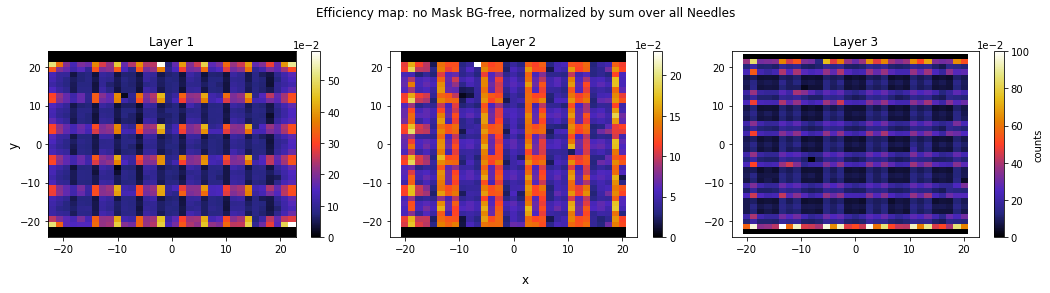

In [13]:
fig = figure_layers(df_pproc, coord,
                    label="Efficiency map: no Mask BG-free, normalized by sum over all Needles",
                    column="efficiency_map")
fig.savefig(f"./figures/efficiency_layers.png", facecolor="white", dpi=600)
# fig

In [29]:
# # save preprocessed data
# import pickle
# with open("preprocess_data_normalized.pkl", "wb") as f:
#     pickle.dump((mapping, coord, df_all), f)

## Data with source

### Single source

In [14]:
hypmed_import = HypmedImporter(
    "../../sifi_cm/data/hypmed/preprocess_data_normalized.pkl")


In [15]:
df_source = hypmed_import.process_file(hypmed_data + 
                                       "ordered_2021-12-10_-_12-15-09_-_TestCodedMaskWithSource4_7_20min_idByMinQf.root")

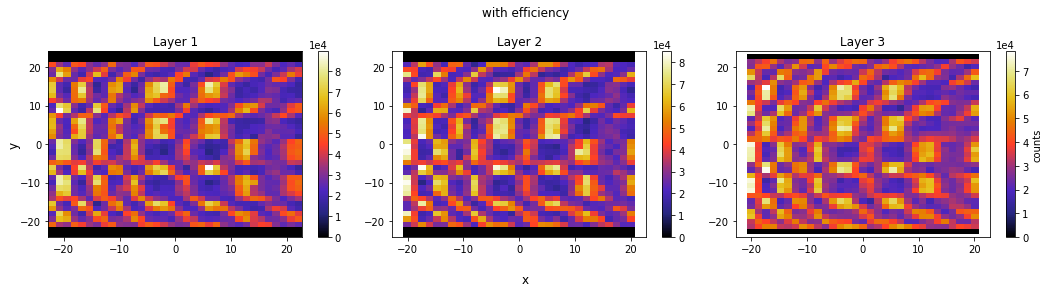

In [16]:
fig = figure_layers(df_source, coord, label="with efficiency", column="PhotonsRoi_norm")
fig.savefig(f"./figures/source_norm_layers.png", facecolor="white", dpi=600)
# fig

In [17]:
matrix_all = raux.get_hmat(hypmed_data + "matr220_170_n1e6_nowallpetcut31_mask467_70mm_hypmed_large.root",
                           hypmed=True)

In [18]:
edges = raux.get_source_edges(hypmed_data + "sim220_170_n1e6_nowallpetcut31_mask467_70mm_hypmed_0_0.root")

In [19]:
fname = hypmed_data + "ordered_2021-12-10_-_12-15-09_-_TestCodedMaskWithSource4_7_20min_idByMinQf.root"
df_source = hypmed_import.process_file(fname)
basename = os.path.basename(fname)
true_pos = basename[basename.find("WithSource")+10:].split("_")[:2]
true_pos = list(map(lambda x: [(int(x)-7)*10], true_pos))

In [20]:
image = get_vec_from_layers(df_source, hypmed_import.coord, column="PhotonsRoi_norm")
reco_obj = raux.reco_mlem(matrix_all, image, 100, keep_all=False)

reco = Reco_image(reco_obj, edges, true_pos=true_pos)

Reconstruction: 100%|██████████| 100/100 [00:06<00:00, 15.03it/s]


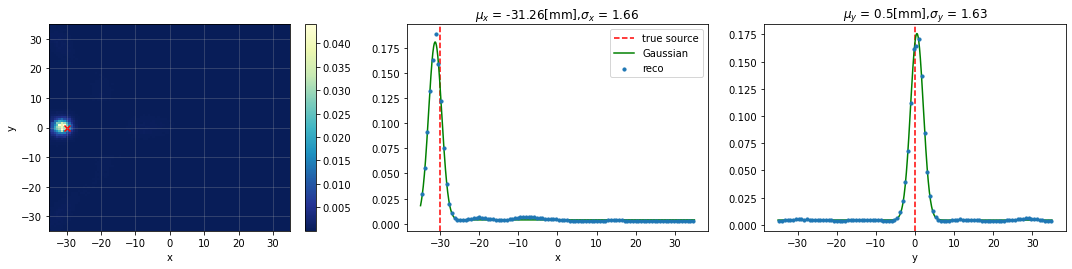

In [21]:
fig = reco.plot()

## All files

In [22]:
from matplotlib.lines import Line2D


In [24]:
import pickle
# reconstructed data for all files
with open("../../sifi_cm/data/hypmed/reconstructed_data.pkl", "rb") as f:
    all_reco_one_source, all_reco_two_source = pickle.load(f)

In [25]:
from scipy.ndimage import gaussian_filter

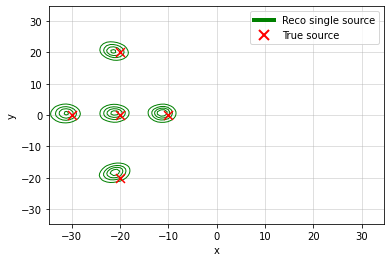

In [26]:
plt.figure(figsize=(6,4))
for data in all_reco_one_source:
    # print(data["true_pos"])
    
    plt.contour(edges.x_cent, edges.y_cent, gaussian_filter(data["reco"], 1), colors='green',
    # plt.contour(edges.x_cent, edges.y_cent, gaussian_filter(data["reco"], 1), colors='green',
                levels=4, zorder=2, linewidths=1);
    plt.scatter(data["true_pos"][0], data["true_pos"][1], marker="x", c="r", zorder=3, s=80)
plt.grid(alpha=0.5)
plt.xlim([edges.x_cent.min(), edges.x_cent.max()])
plt.ylim([edges.y_cent.min(), edges.y_cent.max()])

legend_elements = [Line2D([0], [0], color='g', lw=4, label='Reco single source'),
                   Line2D([0], [0], marker='x', color='r', lw=0, markersize=10, markeredgewidth=2,
                    label='True source')]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlabel("x")
plt.ylabel("y")
# plt.savefig(f"./figures_report/map_SingleSource_corrected.png", facecolor="white", dpi=800)
# plt.savefig(f"./figures/map_SingleSource.png", facecolor="white", dpi=600)
plt.show()

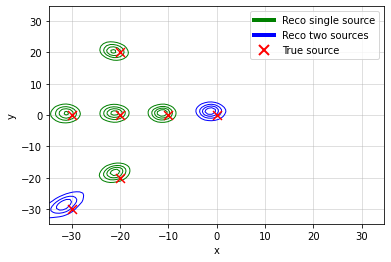

In [27]:
plt.figure(figsize=(6,4))
for data in all_reco_one_source:
    # print(data["true_pos"])
    plt.contour(edges.x_cent, edges.y_cent, gaussian_filter(data["reco"], 1), colors='green',
    # plt.contour(edges.x_cent, edges.y_cent, gaussian_filter(data["reco"], 1), colors='green',
                levels=4, zorder=2, linewidths=1);
    plt.scatter(data["true_pos"][0], data["true_pos"][1], marker="x", c="r", zorder=3, s=80)
for data in all_reco_two_source[:-1]:
    # print(data["true_pos"])
    plt.contour(edges.x_cent, edges.y_cent, gaussian_filter(data["reco"], 1), colors='blue',
    # plt.contour(edges.x_cent, edges.y_cent, gaussian_filter(data["reco"], 1), colors='green',
                levels=4, zorder=2, linewidths=1);
    plt.scatter(data["true_pos"][0], data["true_pos"][1], marker="x", c="r", zorder=3, s=80)
plt.grid(alpha=0.5)
plt.xlim([edges.x_cent.min(), edges.x_cent.max()])
plt.ylim([edges.y_cent.min(), edges.y_cent.max()])

legend_elements = [Line2D([0], [0], color='g', lw=4, label='Reco single source'),
                   Line2D([0], [0], color='b', lw=4, label='Reco two sources'),
                   Line2D([0], [0], marker='x', color='r', lw=0, markersize=10, markeredgewidth=2,
                    label='True source')]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlabel("x")
plt.ylabel("y")
# plt.savefig(f"./figures_report/map_SingleSource_corrected.png", facecolor="white", dpi=800)
plt.savefig(f"./figures/map_Single_TwoSources.png", facecolor="white", dpi=600)
plt.show()

In [28]:
distx3= []
disty3= []

for data in all_reco_two_source:
    distx3.append(data['true_pos'][0]-data['fitx'].mean)
    disty3.append(data['true_pos'][1]-data['fity'].mean)
for data in all_reco_one_source:
    distx3.append(data['true_pos'][0]-data['fitx'].mean)
    disty3.append(data['true_pos'][1]-data['fity'].mean)
distx3=np.array(distx3)
disty3=np.array(disty3)

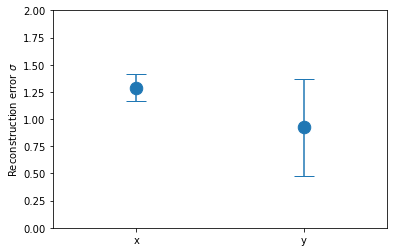

In [29]:
plt.errorbar(range(2), [distx3.mean(), -disty3.mean()], yerr=[distx3.std(), disty3.std()], fmt=".", capsize=10, markersize=25)
plt.xlim([-0.5, 1.5])
plt.ylim([0, 2])
plt.xticks(ticks=[0,1], labels=["x", "y"])
plt.ylabel("Reconstruction error $\sigma$")
plt.savefig(f"./figures/Reco_error.png", facecolor="white", dpi=600)

### Corrections 

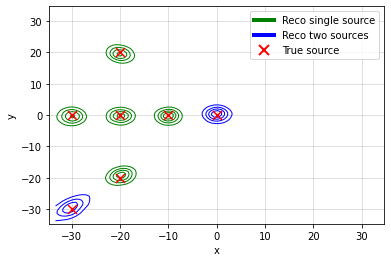

In [30]:
plt.figure(figsize=(6,4))
for data in all_reco_one_source:
    # print(data["true_pos"])
    plt.contour(edges.x_cent+distx3.mean(), edges.y_cent+disty3.mean(),
                gaussian_filter(data["reco"], 1), colors='green',
    # plt.contour(edges.x_cent, edges.y_cent, gaussian_filter(data["reco"], 1), colors='green',
                levels=4, zorder=2, linewidths=1);
    plt.scatter(data["true_pos"][0], data["true_pos"][1], marker="x", c="r", zorder=3, s=80)
for data in all_reco_two_source[:-1]:
    # print(data["true_pos"])
    plt.contour(edges.x_cent+distx3.mean(), edges.y_cent+disty3.mean(),
                gaussian_filter(data["reco"], 1), colors='blue',
    # plt.contour(edges.x_cent, edges.y_cent, gaussian_filter(data["reco"], 1), colors='green',
                levels=4, zorder=2, linewidths=1);
    plt.scatter(data["true_pos"][0], data["true_pos"][1], marker="x", c="r", zorder=3, s=80)
plt.grid(alpha=0.5)
plt.xlim([edges.x_cent.min(), edges.x_cent.max()])
plt.ylim([edges.y_cent.min(), edges.y_cent.max()])

legend_elements = [Line2D([0], [0], color='g', lw=4, label='Reco single source'),
                   Line2D([0], [0], color='b', lw=4, label='Reco two sources'),
                   Line2D([0], [0], marker='x', color='r', lw=0, markersize=10, markeredgewidth=2,
                    label='True source')]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlabel("x")
plt.ylabel("y")
plt.savefig(f"./figures/map_Single_TwoSources_corrected.png", facecolor="white", dpi=600)
plt.show()

In [31]:
distx4= []
disty4= []

for data in all_reco_two_source:
    distx4.append(data['true_pos'][0]-data['fitx'].mean-distx3.mean())
    disty4.append(data['true_pos'][1]-data['fity'].mean-disty3.mean())
for data in all_reco_one_source:
    distx4.append(data['true_pos'][0]-data['fitx'].mean-distx3.mean())
    disty4.append(data['true_pos'][1]-data['fity'].mean-disty3.mean())
distx4=np.array(distx4)
disty4=np.array(disty4)

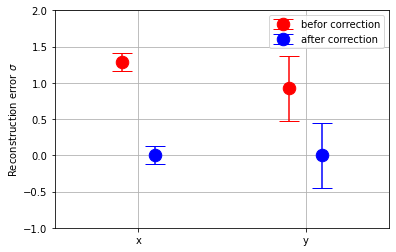

In [32]:
plt.errorbar(np.arange(2)-0.1, [distx3.mean(), -disty3.mean()], yerr=[distx3.std(), disty4.std()],
             fmt=".", capsize=10, markersize=25, c="r", label="befor correction")
plt.errorbar(np.arange(2)+0.1, [distx4.mean(), -disty4.mean()], yerr=[distx4.std(), disty4.std()],
             fmt=".", capsize=10, markersize=25, c="b", label="after correction")
plt.xlim([-0.5, 1.5])
plt.ylim([-1, 2])
plt.legend()
plt.xticks(ticks=[0,1], labels=["x", "y"])
plt.grid()
plt.ylabel("Reconstruction error $\sigma$")
plt.savefig(f"./figures/Reco_error_corrected.png", facecolor="white", dpi=600)